In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
Feb5 = pd.read_csv('/Users/sa3/Downloads/archive/csv-daily-data-20230612T101401Z-001/csv-daily-data/2023-02-05.csv')
Feb6 = pd.read_csv('/Users/sa3/Downloads/archive/csv-daily-data-20230612T101401Z-001/csv-daily-data/2023-02-06.csv')
Feb7 = pd.read_csv('/Users/sa3/Downloads/archive/csv-daily-data-20230612T101401Z-001/csv-daily-data/2023-02-07.csv')
Feb8 = pd.read_csv('/Users/sa3/Downloads/archive/csv-daily-data-20230612T101401Z-001/csv-daily-data/2023-02-08.csv')
Feb9 = pd.read_csv('/Users/sa3/Downloads/archive/csv-daily-data-20230612T101401Z-001/csv-daily-data/2023-02-09.csv')
Feb10 = pd.read_csv('/Users/sa3/Downloads/archive/csv-daily-data-20230612T101401Z-001/csv-daily-data/2023-02-10.csv')
Feb11 = pd.read_csv('/Users/sa3/Downloads/archive/csv-daily-data-20230612T101401Z-001/csv-daily-data/2023-02-11.csv')
Feb12 = pd.read_csv('/Users/sa3/Downloads/archive/csv-daily-data-20230612T101401Z-001/csv-daily-data/2023-02-12.csv')

In [3]:
Feb12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76303 entries, 0 to 76302
Data columns (total 84 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Flow ID                     76303 non-null  object 
 1   Src IP                      76303 non-null  object 
 2   Src Port                    76303 non-null  int64  
 3   Dst IP                      76303 non-null  object 
 4   Dst Port                    76303 non-null  int64  
 5   Protocol                    76303 non-null  int64  
 6   Timestamp                   76303 non-null  object 
 7   Flow Duration               76303 non-null  int64  
 8   Total Fwd Packet            76303 non-null  int64  
 9   Total Bwd packets           76303 non-null  int64  
 10  Total Length of Fwd Packet  76303 non-null  float64
 11  Total Length of Bwd Packet  76303 non-null  float64
 12  Fwd Packet Length Max       76303 non-null  float64
 13  Fwd Packet Length Min       763

In [4]:
Feb12.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,103.82.22.31-10.1.0.4-60519-5555-6,103.82.22.31,60519,10.1.0.4,5555,6,2023-02-12 00:00:01,1274320,2,2,...,20,0.0,0.0,0.0,0.0,1.676160e+15,0.000000e+00,1.676160e+15,1.676160e+15,adbhoney
1,38.60.47.125-10.1.0.4-12043-123-17,38.60.47.125,12043,10.1.0.4,123,17,2023-02-12 00:00:03,63952797,1410,20,...,8,0.0,0.0,0.0,0.0,1.676160e+15,0.000000e+00,1.676160e+15,1.676160e+15,ddospot
2,23.225.116.10-10.1.0.4-42806-123-17,23.225.116.10,42806,10.1.0.4,123,17,2023-02-12 00:00:06,55956907,9,0,...,8,4466157.0,0.0,4466157.0,4466157.0,2.095200e+14,5.926121e+14,1.676160e+15,5.307760e+06,ddospot
3,23.225.116.10-10.1.0.4-36329-123-17,23.225.116.10,36329,10.1.0.4,123,17,2023-02-12 00:00:06,51896382,8,0,...,8,4591215.0,0.0,4591215.0,4591215.0,2.394514e+14,6.335289e+14,1.676160e+15,5.296391e+06,ddospot
4,23.225.116.10-10.1.0.4-26471-123-17,23.225.116.10,26471,10.1.0.4,123,17,2023-02-12 00:00:06,51183146,9,0,...,8,8774430.0,0.0,8774430.0,8774430.0,2.394514e+14,6.335289e+14,1.676160e+15,5.186569e+06,ddospot


In [5]:
Feb12.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,76303.000000,76303.000000,76303.000000,7.630300e+04,76303.000000,76303.000000,76303.000000,7.630300e+04,76303.000000,76303.000000,...,76303.000000,76303.000000,7.630300e+04,7.630300e+04,7.630300e+04,7.630300e+04,7.630300e+04,7.630300e+04,7.630300e+04,7.630300e+04
mean,33052.752146,618.249545,16.420613,2.633108e+07,201.740508,1.127964,1660.640407,3.473904e+02,30.593266,21.692882,...,200.647878,9.001009,2.956109e+06,9.156033e+05,3.786017e+06,2.261264e+06,1.353433e+15,2.762464e+14,1.676197e+15,1.188979e+15
std,19055.528165,4601.670961,2.457163,3.703047e+07,691.467171,12.456714,6829.640832,1.681182e+04,83.779482,22.376337,...,691.490366,4.453928,1.122288e+07,4.895714e+06,1.354739e+07,1.025446e+07,5.198852e+14,4.464832e+14,2.243463e+10,7.611197e+14
min,1.000000,19.000000,6.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,8.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.822238e+13,0.000000e+00,1.676160e+15,5.000054e+06
25%,16414.500000,123.000000,17.000000,5.160000e+02,1.000000,0.000000,48.000000,0.000000e+00,8.000000,8.000000,...,0.000000,8.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.380998e+14,0.000000e+00,1.676178e+15,1.528216e+07
50%,33778.000000,123.000000,17.000000,9.863739e+06,3.000000,0.000000,48.000000,0.000000e+00,8.000000,8.000000,...,2.000000,8.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.676183e+15,0.000000e+00,1.676192e+15,1.676183e+15
75%,49539.500000,123.000000,17.000000,3.959182e+07,60.000000,1.000000,496.000000,4.800000e+01,48.000000,48.000000,...,59.000000,8.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.676209e+15,6.842934e+14,1.676212e+15,1.676209e+15
max,65535.000000,65363.000000,17.000000,1.200000e+08,13028.000000,2631.000000,785452.000000,3.738491e+06,1460.000000,1336.000000,...,13027.000000,40.000000,1.142716e+08,7.301791e+07,1.142716e+08,1.142716e+08,1.676244e+15,1.185282e+15,1.676244e+15,1.676244e+15


In [6]:
print("Attack Type Counts:")
print(Feb12["Label"].value_counts())

Attack Type Counts:
Label
ddospot       72287
cowrie         2106
log4pot        1388
ciscoasa        195
adbhoney        180
elasticpot       63
mailoney         49
redispot         35
Name: count, dtype: int64


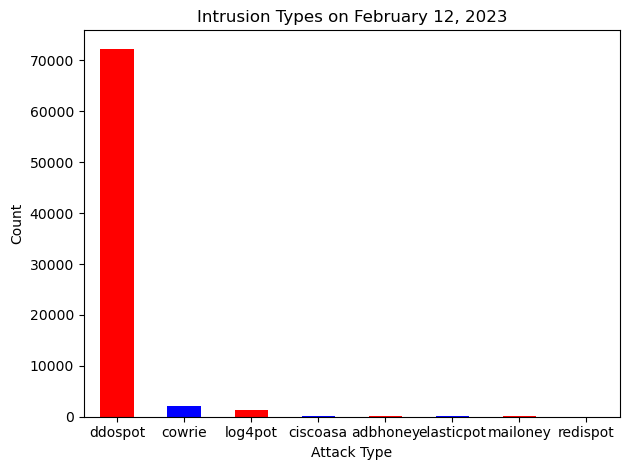

In [7]:
Feb12["Label"].value_counts().plot(kind='bar', color=['red', 'blue'])
plt.title("Intrusion Types on February 12, 2023")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
print("\nProtocol Distribution:")
print(Feb12["Protocol"].value_counts())


Protocol Distribution:
Protocol
17    72284
6      4019
Name: count, dtype: int64


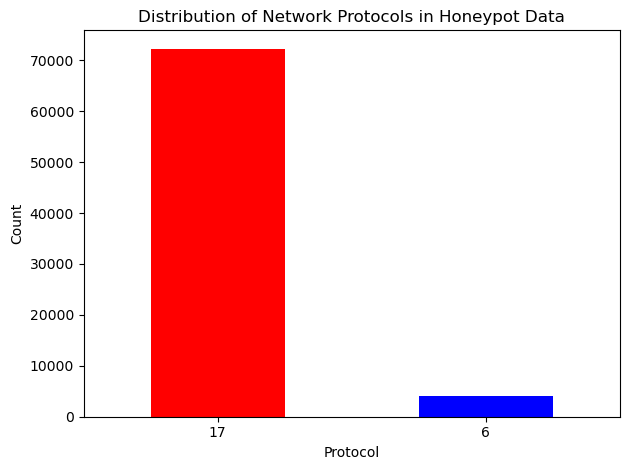

In [9]:
Feb12["Protocol"].value_counts().plot(kind='bar', color=['red','blue'])
plt.title("Distribution of Network Protocols in Honeypot Data")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [10]:
print("\nTop 10 Targeted Ports:")
print(Feb12["Dst Port"].value_counts().head(10))


Top 10 Targeted Ports:
Dst Port
123     72220
22        997
23        598
80        560
443       503
8080      166
5555      147
8443      137
25         43
9200       42
Name: count, dtype: int64


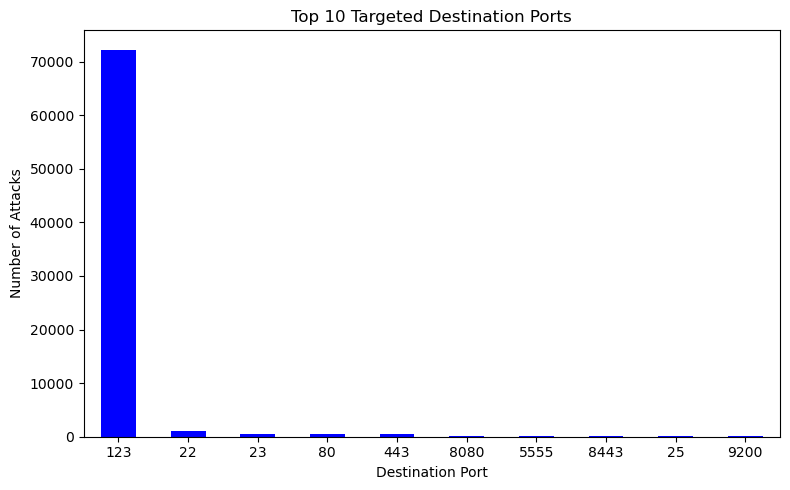

In [11]:
top_ports = Feb12["Dst Port"].value_counts().head(10)
plt.figure(figsize=(8, 5))
top_ports.plot(kind='bar', color='blue')
plt.title("Top 10 Targeted Destination Ports")
plt.xlabel("Destination Port")
plt.ylabel("Number of Attacks")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

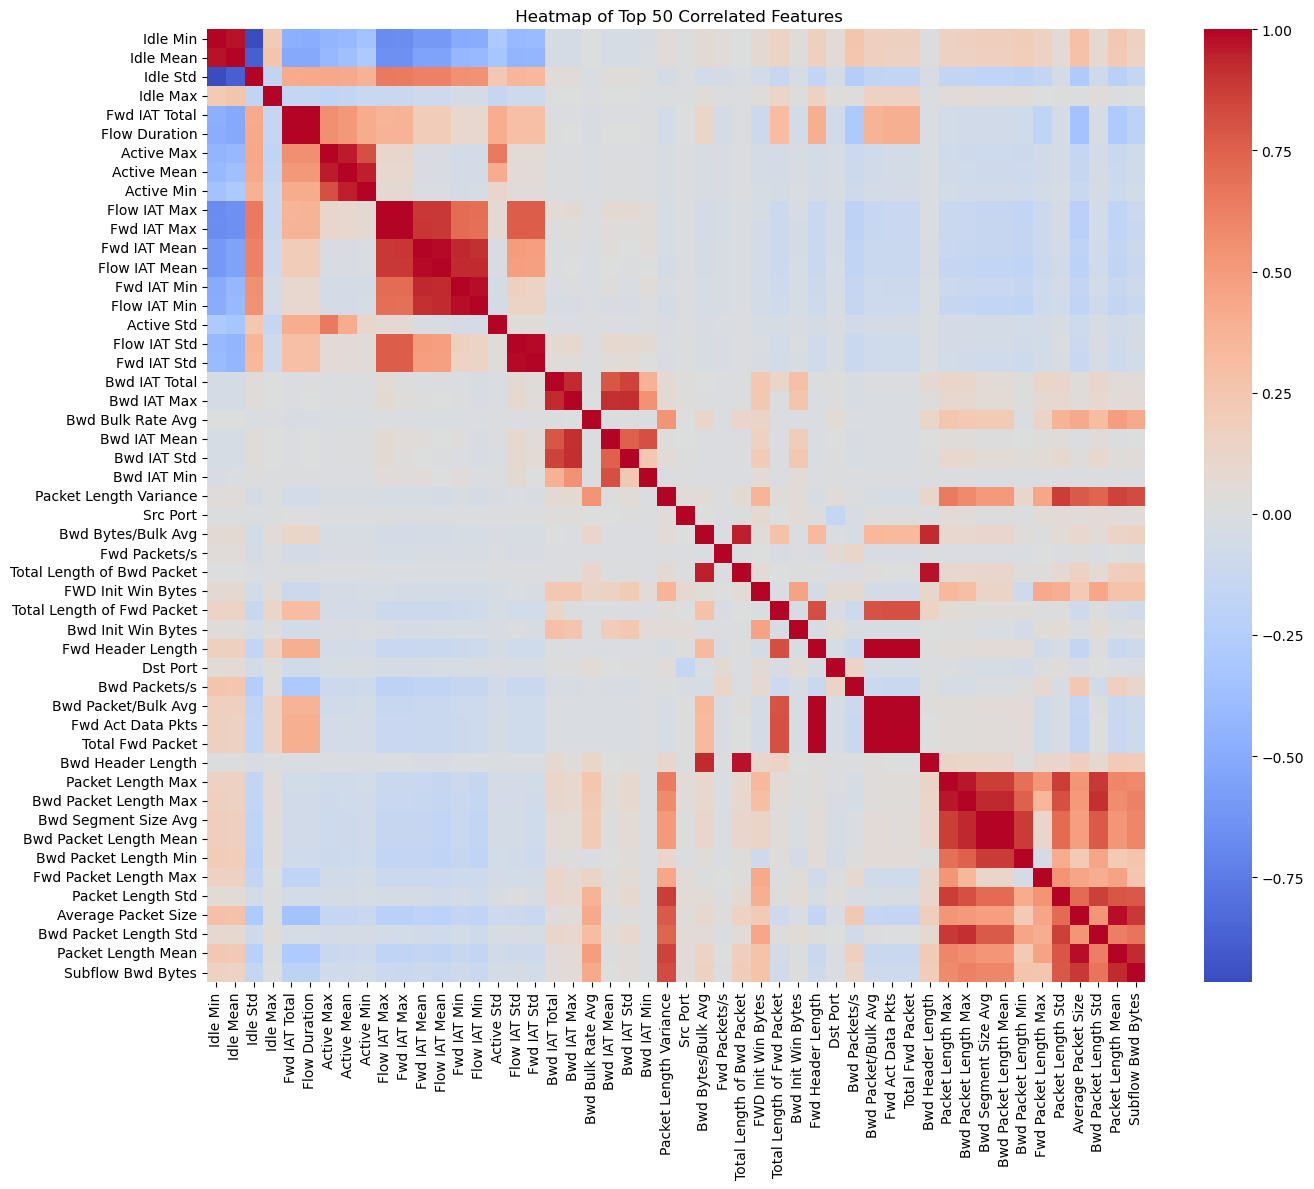

In [12]:
numeric_cols = Feb12.select_dtypes(include='number')
top_50_cols = numeric_cols.var().sort_values(ascending=False).head(50).index
top_50_corr = Feb12[top_50_cols].corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(top_50_corr, annot=False, cmap='coolwarm')
plt.title(" Heatmap of Top 50 Correlated Features")
plt.tight_layout()
plt.show()